In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
WINDOW_SIZES = ["1d", "7d", "14d"]
MODEL_NAMES = ["all-MiniLM-L12-v2"]
ORG_NAME = "Aave - Aavegotchi"
SPLITS_FREQ = "5d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2023-05-01"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1081 non-null   object        
 1   author             1081 non-null   object        
 2   date               1081 non-null   datetime64[us]
 3   start              1081 non-null   datetime64[us]
 4   end                1081 non-null   datetime64[us]
 5   platform_proposal  1081 non-null   object        
 6   title              1081 non-null   object        
 7   description        878 non-null    object        
dtypes: datetime64[us](3), object(5)
memory usage: 67.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328356 entries, 0 to 2328355
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   id        object        
 1   proposal  object        
 2   voter     object        
 3   date      da

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0x7e741fbdc71b8fa2310e9836146296c327b79dce-vot...,05fecd7e-ef0d-5804-a509-7c9bde951705,2019-12-13 15:27:14,1
1,0x7e741fbdc71b8fa2310e9836146296c327b79dce-vot...,05fecd7e-ef0d-5804-a509-7c9bde951705,2019-12-13 15:29:30,1
2,0x7e741fbdc71b8fa2310e9836146296c327b79dce-vot...,05fecd7e-ef0d-5804-a509-7c9bde951705,2019-12-13 15:31:45,1
3,0x7e741fbdc71b8fa2310e9836146296c327b79dce-vot...,a0847e79-6ad8-58ec-b525-d8dbff21b7af,2020-01-13 13:14:17,1
4,0x7e741fbdc71b8fa2310e9836146296c327b79dce-vot...,a0847e79-6ad8-58ec-b525-d8dbff21b7af,2020-01-13 13:17:14,1
...,...,...,...,...
2328351,0x4da0878ddd74208c1e67915f5c25db99b22ffdd1,a6bc61cd-cc0d-57f1-8c26-ecd7027eb461,2023-07-20 16:28:43,1
2328352,0x2415b3876ceb4bfd0c90467419039979b3ff7daa,a6bc61cd-cc0d-57f1-8c26-ecd7027eb461,2023-07-20 16:30:21,1
2328353,0x2975e77ff2954f27e0b18403ccf02c528053ae4c,a6bc61cd-cc0d-57f1-8c26-ecd7027eb461,2023-07-20 16:32:03,1
2328354,0xb7b827186385ed69023ed824fc8950ef07731be9,a6bc61cd-cc0d-57f1-8c26-ecd7027eb461,2023-07-20 16:33:32,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2023-03-17 00:00:00'),
 Timestamp('2023-03-22 00:00:00'),
 Timestamp('2023-03-27 00:00:00'),
 Timestamp('2023-04-01 00:00:00'),
 Timestamp('2023-04-06 00:00:00'),
 Timestamp('2023-04-11 00:00:00'),
 Timestamp('2023-04-16 00:00:00'),
 Timestamp('2023-04-21 00:00:00'),
 Timestamp('2023-04-26 00:00:00'),
 Timestamp('2023-05-01 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/Aave - Aavegotchi/hparams-pln-similarity_5d_normalize.pkl with 99 results


  0%|          | 0/30 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2023-03-17,all-MiniLM-L12-v2,7d,810.222255,0.037907,2769,0.786927,0.562538,0.349729,0.174865,...,1.000000,1.0,1.0,0.588649,0.978736,0.989069,0.989069,0.989069,0.989069,0.790585
1,2023-03-17,all-MiniLM-L12-v2,14d,1468.719165,0.047957,3353,0.822845,0.563078,0.350313,0.175157,...,1.000000,1.0,1.0,0.607134,0.973602,0.982940,0.982940,0.982940,0.982940,0.888186
2,2023-03-22,all-MiniLM-L12-v2,7d,406.567510,0.025168,1625,0.956923,0.421949,0.269785,0.134892,...,1.000000,1.0,1.0,0.848896,0.947092,0.947990,0.947990,0.947990,0.947990,0.430426
3,2023-03-27,all-MiniLM-L12-v2,7d,415.712683,0.029031,2369,0.831575,0.593359,0.447108,0.223554,...,1.000000,1.0,1.0,0.611481,0.861645,0.938137,0.938137,0.938137,0.938137,0.747392
4,2023-04-01,all-MiniLM-L12-v2,7d,1062.514449,0.076570,14993,0.902088,0.632006,0.398333,0.204916,...,0.999320,1.0,1.0,0.496494,0.961038,0.965149,0.967599,0.967606,0.967606,5.417772
5,2023-04-06,all-MiniLM-L12-v2,7d,540.391823,0.070945,12312,0.377274,0.417289,0.405344,0.243917,...,0.981283,1.0,1.0,0.428136,0.534304,0.578812,0.590589,0.591636,0.591636,5.334083
6,2023-03-17,all-MiniLM-L12-v2,1d,117.149477,0.016059,341,0.824047,0.513196,0.309091,0.154545,...,1.000000,1.0,1.0,0.730427,0.952419,0.953226,0.953226,0.953226,0.953226,0.510874
7,2023-03-22,all-MiniLM-L12-v2,1d,1.342053,0.004226,81,0.506173,0.374486,0.237037,0.118519,...,1.000000,1.0,1.0,0.884146,0.895833,0.901515,0.901515,0.901515,0.901515,0.247942
8,2023-03-27,all-MiniLM-L12-v2,1d,173.469835,0.017370,465,0.350538,0.412903,0.279140,0.139570,...,1.000000,1.0,1.0,0.723517,0.882190,0.946190,0.946190,0.946190,0.946190,0.547051
9,2023-04-01,all-MiniLM-L12-v2,1d,2.615408,0.017129,716,0.325419,0.280726,0.220950,0.187570,...,0.999825,1.0,1.0,0.476758,0.747518,0.793642,0.838943,0.838943,0.838943,2.304016


<Axes: xlabel='window_size', ylabel='map@10'>

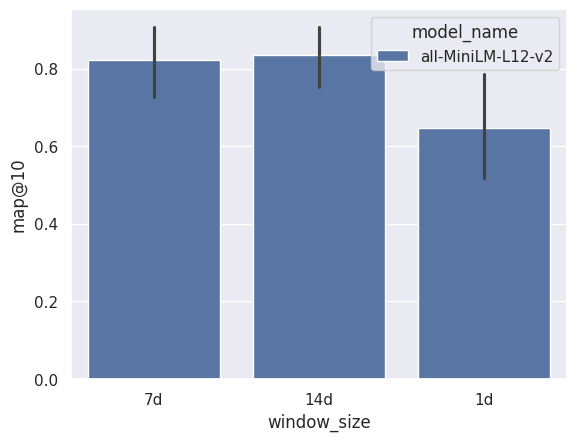

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
window_size,model_name,,,,,,,,,,,,,,,,
14d,all-MiniLM-L12-v2,1162.993568,0.358407,0.192634,0.019313,0.725891,0.739901,0.740269,0.813532,0.825436,0.825758,0.954095,0.998917,1.0,0.877317,0.882954,0.883070
7d,all-MiniLM-L12-v2,501.485373,0.348890,0.186805,0.018769,0.599719,0.612783,0.613496,0.803681,0.815396,0.816057,0.942076,0.997845,1.0,0.861541,0.866100,0.866217
1d,all-MiniLM-L12-v2,50.179646,0.243634,0.158338,0.016322,0.039612,0.043046,0.044757,0.573589,0.615753,0.619541,0.753458,0.954406,1.0,0.832835,0.844474,0.844474


In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Aave - Aavegotchi/models/plnsim-best-avg_5d_normalize.parquet


/tmp/ipykernel_3824926/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2023-03-17,14d,all-MiniLM-L12-v2,1468.719165,0.047957,3353,0.822845,0.563078,0.350313,0.175157,0.116771,0.017516,0.722819,...,1.000000,1.0,1.0,0.607134,0.973602,0.982940,0.982940,0.982940,0.982940,0.888186
2023-03-22,14d,all-MiniLM-L12-v2,1632.205765,0.054173,2467,0.764086,0.431969,0.270126,0.135063,0.090042,0.013506,0.597464,...,1.000000,1.0,1.0,0.822538,0.963733,0.964931,0.964931,0.964931,0.964931,0.709106
2023-03-27,14d,all-MiniLM-L12-v2,998.678944,0.044277,2872,0.778900,0.597957,0.471170,0.235585,0.157057,0.023558,0.596692,...,1.000000,1.0,1.0,0.566197,0.831914,0.928379,0.928379,0.928379,0.928379,0.834445
2023-04-01,14d,all-MiniLM-L12-v2,1487.760381,0.086020,15286,0.890357,0.628244,0.398705,0.206163,0.137982,0.020697,0.828413,...,0.998099,1.0,1.0,0.494299,0.953184,0.958722,0.961565,0.961571,0.961571,5.687071
2023-04-06,14d,all-MiniLM-L12-v2,1689.006760,0.084403,13372,0.782381,0.430078,0.400419,0.249940,0.169080,0.025362,0.718002,...,0.992157,1.0,1.0,0.451499,0.541090,0.578535,0.589519,0.590550,0.590550,6.103209
2023-04-11,14d,all-MiniLM-L12-v2,1320.772174,0.048369,1259,0.598094,0.392375,0.292454,0.199444,0.132963,0.019944,0.448481,...,1.000000,1.0,1.0,0.679397,0.874899,0.906763,0.938897,0.938897,0.938897,0.414050
2023-04-16,14d,all-MiniLM-L12-v2,1078.776670,0.050672,1910,0.269634,0.356195,0.304398,0.155707,0.103805,0.015571,0.213870,...,1.000000,1.0,1.0,0.745372,0.659748,0.660774,0.660912,0.660912,0.660912,0.477761
2023-04-21,14d,all-MiniLM-L12-v2,596.988884,0.056836,13187,0.959657,0.337428,0.213301,0.111997,0.074664,0.011200,0.934086,...,1.000000,1.0,1.0,0.983349,0.986520,0.992080,0.996410,0.996410,0.996410,3.584824
2023-04-26,14d,all-MiniLM-L12-v2,773.999231,0.064415,16543,0.929759,0.892281,0.556284,0.278142,0.185428,0.027814,0.886666,...,1.000000,1.0,1.0,0.365278,0.952896,0.954820,0.954820,0.954820,0.954820,5.274339


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/Aave - Aavegotchi/models/plnsim-best-val_5d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-03-17,all-MiniLM-L12-v2,1d,117.149477,0.309091,0.154545,0.015455,0.083889,0.083889,0.083889,0.917400,0.917400,0.917400,1.000000,1.000000,1.0,0.953226,0.953226,0.953226
2023-03-22,all-MiniLM-L12-v2,7d,406.567510,0.269785,0.134892,0.013489,0.499949,0.499949,0.499949,0.953780,0.953780,0.953780,1.000000,1.000000,1.0,0.947990,0.947990,0.947990
2023-03-27,all-MiniLM-L12-v2,7d,415.712683,0.447108,0.223554,0.022355,0.581816,0.581816,0.581816,0.888381,0.888381,0.888381,1.000000,1.000000,1.0,0.938137,0.938137,0.938137
2023-04-01,all-MiniLM-L12-v2,7d,1062.514449,0.398333,0.204916,0.020522,0.864525,0.870839,0.871109,0.931348,0.936102,0.936375,0.980414,0.999320,1.0,0.965149,0.967599,0.967606
2023-04-06,all-MiniLM-L12-v2,14d,1689.006760,0.400419,0.249940,0.025362,0.685524,0.736596,0.739155,0.620689,0.668701,0.670871,0.860402,0.992157,1.0,0.578535,0.589519,0.590550
2023-04-11,all-MiniLM-L12-v2,14d,1320.772174,0.292454,0.199444,0.019944,0.535220,0.590612,0.590612,0.670866,0.712678,0.712678,0.789553,1.000000,1.0,0.906763,0.938897,0.938897
2023-04-16,all-MiniLM-L12-v2,7d,523.697332,0.260400,0.132700,0.013270,0.301225,0.303546,0.303546,0.630700,0.634700,0.634700,0.986500,1.000000,1.0,0.799871,0.800193,0.800193
2023-04-21,all-MiniLM-L12-v2,7d,152.469252,0.210180,0.107847,0.010785,0.917000,0.918435,0.918435,0.990844,0.991993,0.991993,0.993749,1.000000,1.0,0.994683,0.997096,0.997096
2023-04-26,all-MiniLM-L12-v2,1d,2.313025,0.386337,0.193168,0.019317,0.057552,0.057552,0.057552,0.983911,0.983911,0.983911,1.000000,1.000000,1.0,0.994914,0.994914,0.994914


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,592.252497,0.324839,0.173815,0.017421,0.460809,0.472462,0.472745,0.852366,0.862338,0.862583,0.961062,0.999148,1.0,0.902883,0.907713,0.907817
std,569.777020,0.077480,0.046596,0.004730,0.319273,0.326368,0.326636,0.149530,0.135893,0.135567,0.073951,0.002466,0.0,0.126751,0.124423,0.124131
min,2.313025,0.210180,0.107847,0.010785,0.057552,0.057552,0.057552,0.620689,0.634700,0.634700,0.789553,0.992157,1.0,0.578535,0.589519,0.590550
25%,172.432517,0.270910,0.135455,0.013545,0.138223,0.138803,0.138803,0.725245,0.756604,0.756604,0.981936,1.000000,1.0,0.914607,0.938327,0.938327
50%,411.140097,0.300773,0.173857,0.017386,0.517584,0.540883,0.540883,0.924374,0.926568,0.926568,0.996874,1.000000,1.0,0.948776,0.948776,0.948776
75%,927.810170,0.395334,0.203548,0.020378,0.659597,0.700100,0.702019,0.949269,0.949361,0.949429,1.000000,1.000000,1.0,0.962168,0.964006,0.964011
max,1689.006760,0.447108,0.249940,0.025362,0.917000,0.918435,0.918435,0.990844,0.991993,0.991993,1.000000,1.000000,1.0,0.994914,0.997096,0.997096


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Aave - Aavegotchi/models/plnsim-best-test_5d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-03-22,all-MiniLM-L12-v2,1d,1.342053,0.237037,0.118519,0.011852,0.020782,0.020782,0.020782,0.737311,0.737311,0.737311,1.000000,1.000000,1.0,0.901515,0.901515,0.901515
2023-03-27,all-MiniLM-L12-v2,7d,415.712683,0.447108,0.223554,0.022355,0.581816,0.581816,0.581816,0.888381,0.888381,0.888381,1.000000,1.000000,1.0,0.938137,0.938137,0.938137
2023-04-01,all-MiniLM-L12-v2,7d,1062.514449,0.398333,0.204916,0.020522,0.864525,0.870839,0.871109,0.931348,0.936102,0.936375,0.980414,0.999320,1.0,0.965149,0.967599,0.967606
2023-04-06,all-MiniLM-L12-v2,7d,540.391823,0.405344,0.243917,0.025156,0.553848,0.595822,0.601974,0.524539,0.563537,0.569214,0.857034,0.981283,1.0,0.578812,0.590589,0.591636
2023-04-11,all-MiniLM-L12-v2,14d,1320.772174,0.292454,0.199444,0.019944,0.535220,0.590612,0.590612,0.670866,0.712678,0.712678,0.789553,1.000000,1.0,0.906763,0.938897,0.938897
2023-04-16,all-MiniLM-L12-v2,14d,1078.776670,0.304398,0.155707,0.015571,0.555702,0.561792,0.561792,0.581952,0.587712,0.587712,0.981937,1.000000,1.0,0.660774,0.660912,0.660912
2023-04-21,all-MiniLM-L12-v2,7d,152.469252,0.210180,0.107847,0.010785,0.917000,0.918435,0.918435,0.990844,0.991993,0.991993,0.993749,1.000000,1.0,0.994683,0.997096,0.997096
2023-04-26,all-MiniLM-L12-v2,7d,200.092759,0.564318,0.282159,0.028216,0.758217,0.758217,0.758217,0.794315,0.794315,0.794315,1.000000,1.000000,1.0,0.673972,0.673972,0.673972
2023-05-01,all-MiniLM-L12-v2,1d,232.322312,0.274286,0.137143,0.013714,0.081390,0.081390,0.081390,0.935737,0.935737,0.935737,1.000000,1.000000,1.0,0.949561,0.949561,0.949561


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,9.000000
mean,556.043797,0.348162,0.185912,0.018679,0.540944,0.553300,0.554014,0.783921,0.794196,0.794857,0.955854,0.997845,1.0,0.841041,0.846475,0.846592
std,479.136287,0.114108,0.059704,0.006069,0.311684,0.313549,0.313695,0.166450,0.155678,0.154666,0.077408,0.006215,0.0,0.157068,0.157173,0.156961
min,1.342053,0.210180,0.107847,0.010785,0.020782,0.020782,0.020782,0.524539,0.563537,0.569214,0.789553,0.981283,1.0,0.578812,0.590589,0.591636
25%,200.092759,0.274286,0.137143,0.013714,0.535220,0.561792,0.561792,0.670866,0.712678,0.712678,0.980414,1.000000,1.0,0.673972,0.673972,0.673972
50%,415.712683,0.304398,0.199444,0.019944,0.555702,0.590612,0.590612,0.794315,0.794315,0.794315,0.993749,1.000000,1.0,0.906763,0.938137,0.938137
75%,1062.514449,0.405344,0.223554,0.022355,0.758217,0.758217,0.758217,0.931348,0.935737,0.935737,1.000000,1.000000,1.0,0.949561,0.949561,0.949561
max,1320.772174,0.564318,0.282159,0.028216,0.917000,0.918435,0.918435,0.990844,0.991993,0.991993,1.000000,1.000000,1.0,0.994683,0.997096,0.997096
